# Importing necessary library

In [1]:
import os
import re
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
IEMOCAP_ROOT = "IEMOCAP_full_release"

# STEP 1: Print IEMOCAP Dataset Directory Structure

__Objective:__ Understand the organization of the IEMOCAP dataset files and examine sample annotation and transcription files.

In [3]:
def print_dir_structure(root, max_depth=3, prefix=''):
    for root_dir, dirs, files in os.walk(root):
        depth = root_dir[len(root):].count(os.sep)
        if depth > max_depth:
            continue
        print(f"{prefix}{os.path.relpath(root_dir, root)}")
        for f in files[:5]:
            if not f.startswith('.') and not f.startswith('._'):
                print(f"{prefix}  - {f}")
        if depth == max_depth:
            dirs[:] = []  # Stop deeper traversal

def print_sample_lines(file_path, num_lines=5):
    print(f"\nSample from {file_path}:")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                print(line.strip())
                if i >= num_lines - 1:
                    break
    except Exception as e:
        print(f"Could not read file: {e}")

if __name__ == "__main__":
    print("==== IEMOCAP Directory Structure (up to depth 3) ====")
    print_dir_structure(IEMOCAP_ROOT, max_depth=3, prefix='  ')

    print("\n==== Sample Files from Session 1 ====")
    session1 = os.path.join(IEMOCAP_ROOT, "Session1")

    # EmoEvaluation
    emo_eval_dir = os.path.join(session1, "dialog", "EmoEvaluation")
    if os.path.exists(emo_eval_dir):
        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt') and not f.startswith('._')]
        if emo_files:
            print_sample_lines(os.path.join(emo_eval_dir, emo_files[0]))

    # Transcriptions
    trans_dir = os.path.join(session1, "dialog", "transcriptions")
    if os.path.exists(trans_dir):
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt') and not f.startswith('._')]
        if trans_files:
            print_sample_lines(os.path.join(trans_dir, trans_files[0]))

==== IEMOCAP Directory Structure (up to depth 3) ====
  .
  Documentation
  Session1
  Session1\dialog
  Session1\dialog\avi
  Session1\dialog\EmoEvaluation
  Session1\dialog\lab
  Session1\dialog\MOCAP_hand
  Session1\dialog\MOCAP_head
  Session1\dialog\MOCAP_rotated
  Session1\dialog\transcriptions
  Session1\dialog\wav
  Session1\sentences
  Session1\sentences\ForcedAlignment
  Session1\sentences\MOCAP_hand
  Session1\sentences\MOCAP_head
  Session1\sentences\MOCAP_rotated
  Session1\sentences\wav
  Session2
  Session2\dialog
  Session2\dialog\avi
  Session2\dialog\EmoEvaluation
  Session2\dialog\lab
  Session2\dialog\MOCAP_hand
  Session2\dialog\MOCAP_head
  Session2\dialog\MOCAP_rotated
  Session2\dialog\transcriptions
  Session2\dialog\wav
  Session2\sentences
  Session2\sentences\ForcedAlignment
  Session2\sentences\MOCAP_hand
  Session2\sentences\MOCAP_head
  Session2\sentences\MOCAP_rotated
  Session2\sentences\wav
  Session3
  Session3\dialog
  Session3\dialog\avi
  Session3\

# Step 2: Parsing and Merging Emotion Annotations and Transcriptions

In [4]:
def parse_emotion_labels(base_path):
    emo_data = {}
    sessions = [f'Session{i}' for i in range(1, 6)]

    for session in sessions:
        emo_dir = Path(base_path) / session / 'dialog' / 'EmoEvaluation'
        for emo_file in emo_dir.glob('*.txt'):
            with open(emo_file, 'r') as f:
                for line in f:
                    match = re.match(r'\[(\d+\.\d+)\s*-\s*(\d+\.\d+)\]\s+(\S+)\s+(\w+)', line)
                    if match:
                        start, end, utt_id, emotion = match.groups()
                        emo_data[utt_id] = {
                            'start': float(start),
                            'end': float(end),
                            'emotion': emotion.lower()
                        }
    print(f"✅ Parsed {len(emo_data)} emotion-labeled utterances")
    return emo_data

emo_data = parse_emotion_labels("IEMOCAP_full_release")


def parse_transcriptions(base_path):
    text_data = {}
    sessions = [f'Session{i}' for i in range(1, 6)]

    for session in sessions:
        trans_dir = Path(base_path) / session / 'dialog' / 'transcriptions'
        for trans_file in trans_dir.glob('*.txt'):
            try:
                with open(trans_file, 'r', encoding='utf-8') as f:
                    lines = f.readlines()
            except UnicodeDecodeError:
                with open(trans_file, 'r', encoding='latin-1') as f:
                    lines = f.readlines()

            for line in lines:
                match = re.match(r'^(\S+)\s+\[\d+\.\d+-\d+\.\d+\]:\s*(.*)', line)
                if match:
                    utt_id, text = match.groups()
                    text_data[utt_id] = text.strip()
    print(f"✅ Parsed {len(text_data)} transcribed utterances")
    return text_data

text_data = parse_transcriptions("IEMOCAP_full_release")

def merge_all_emotions(emo_data, text_data):
    merged = []
    for utt_id, emo_info in emo_data.items():
        if utt_id in text_data:
            emotion = emo_info['emotion']
            merged.append({
                'utt_id': utt_id,
                'text': text_data[utt_id],
                'emotion': emotion,
                'start': emo_info['start'],
                'end': emo_info['end']
            })
    
    df = pd.DataFrame(merged)
    print(f"✅ Merged {len(df)} utterances across ALL emotions")
    print("📊 Emotion counts:")
    print(df['emotion'].value_counts())
    return df

import pandas as pd
df_all = merge_all_emotions(emo_data, text_data)

✅ Parsed 10039 emotion-labeled utterances
✅ Parsed 10085 transcribed utterances
✅ Merged 10039 utterances across ALL emotions
📊 Emotion counts:
emotion
xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: count, dtype: int64


# STEP 2: Parse the emotion labels and transcripts from the IEMOCAP Dataset for all 8 emotion classes.

In [5]:
EMOTIONS = {'sur', 'fea', 'fru', 'sad', 'hap', 'exc', 'neu', 'ang'}

def parse_emo_eval_file(file_path):
    """
    Parse an EmoEvaluation .txt file to extract utterance_id and emotion label.
    Returns a dict {utterance_id: emotion}
    """
    utterance_emotions = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            # Skip comments and empty lines
            if line.startswith('%') or not line.strip():
                continue
            # Match lines like: [6.2901 - 8.2357] Ses01F_impro01_F000 neu [2.5, 2.5, 2.5]
            match = re.match(r'\[(.*?) - (.*?)\]\s+(\S+)\s+(\S+)\s+\[.*\]', line)
            if match:
                utterance_id = match.group(3).strip()
                emotion = match.group(4).strip().lower()
                if emotion in EMOTIONS:
                    utterance_emotions[utterance_id] = emotion
    return utterance_emotions

def parse_transcript_file(file_path):
    """
    Parse a transcript .txt file to extract utterance_id and text.
    Returns a dict {utterance_id: text}
    """
    utterance_texts = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            # Match lines like: Ses01F_impro01_F000 [006.2901-008.2357]: Excuse me.
            match = re.match(r'(\S+)\s+\[.*\]:\s+(.*)', line)
            if match:
                utterance_id = match.group(1).strip()
                text = match.group(2).strip()
                utterance_texts[utterance_id] = text
    return utterance_texts

def load_iemocap_text_data(root_dir):
    """
    Load all utterance emotions and texts from IEMOCAP dataset.
    Returns a DataFrame with columns: utterance_id, emotion, text.
    """
    data = []
    for session in range(1, 6):  # Sessions 1 to 5
        emo_eval_dir = os.path.join(root_dir, f"Session{session}", "dialog", "EmoEvaluation")
        trans_dir = os.path.join(root_dir, f"Session{session}", "dialog", "transcriptions")
        if not os.path.exists(emo_eval_dir) or not os.path.exists(trans_dir):
            continue

        # List all emotion files and transcripts
        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt')]
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt')]

        for emo_file in emo_files:
            emo_path = os.path.join(emo_eval_dir, emo_file)
            utterance_emotions = parse_emo_eval_file(emo_path)

            # Find corresponding transcript file (same name)
            if emo_file in trans_files:
                trans_path = os.path.join(trans_dir, emo_file)
                utterance_texts = parse_transcript_file(trans_path)

                # Combine emotion and text for utterances present in both
                for utt_id, emo in utterance_emotions.items():
                    if utt_id in utterance_texts:
                        data.append({
                            'utterance_id': utt_id,
                            'emotion': emo,
                            'text': utterance_texts[utt_id]
                        })

    df = pd.DataFrame(data)
    return df

if __name__ == "__main__":
    df_text = load_iemocap_text_data(IEMOCAP_ROOT)
    print(f"Total utterances loaded: {len(df_text)}")
    print("Sample data:")
    print(df_text.head())

Total utterances loaded: 7527
Sample data:
          utterance_id emotion  \
0  Ses01F_impro01_F000     neu   
1  Ses01F_impro01_F001     neu   
2  Ses01F_impro01_F002     neu   
3  Ses01F_impro01_F005     neu   
4  Ses01F_impro01_F006     fru   

                                                text  
0                                         Excuse me.  
1                                              Yeah.  
2                                Is there a problem?  
3        Well what's the problem?  Let me change it.  
4  What?  I'm getting an ID.  This is why I'm her...  


## Count and display the number of utterances per emotion label 

C:\Users\Rishuraj\AppData\Local\Temp\ipykernel_8892\1824742527.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette=palette)


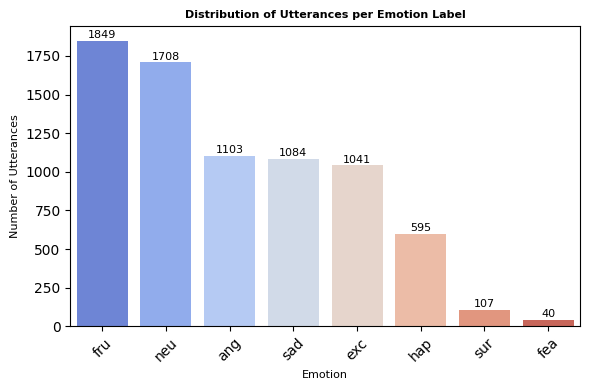

In [6]:
emotion_counts = df_text['emotion'].value_counts().sort_values(ascending=False)

# Create a color palette with a gradient (e.g., from cool to warm colors)
palette = sns.color_palette("coolwarm", n_colors=len(emotion_counts))

plt.figure(figsize=(6,4))

# Barplot with the custom palette
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette=palette)

plt.title('Distribution of Utterances per Emotion Label', fontsize=8, weight='bold')
plt.xlabel('Emotion', fontsize=8)
plt.ylabel('Number of Utterances', fontsize=8)
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, count in enumerate(emotion_counts.values):
    plt.text(i, count + max(emotion_counts.values)*0.01, str(count), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# STEP 3: Create the master CSV File and separate CSVs for text, audio and video modalities.

__Objective__: To consolidate utterance-level data from the IEMOCAP dataset into a single master CSV file and separate CSV files for text, audio, and video modalities. This structured data organization facilitates downstream processing and model training.

In [7]:
import os
import re
import pandas as pd

IEMOCAP_ROOT = "IEMOCAP_full_release"  # Adjust as needed

# Emotions to keep and map to full names
EMOTIONS_MAP = {
    'sur': 'surprise',
    'fea': 'fear',
    'fru': 'frustration',
    'sad': 'sadness',
    'hap': 'happiness',
    'exc': 'excited',
    'neu': 'neutral',
    'ang': 'anger'
}

def parse_emo_eval_file(file_path):
    """
    Parse EmoEvaluation file to extract utterance info:
    utterance_id, emotion, start, end, dialogue
    """
    utterances = []
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            if line.startswith('%') or not line.strip():
                continue
            # Example line:
            # [6.2901 - 8.2357] Ses01F_impro01_F000 neu [2.5, 2.5, 2.5]
            match = re.match(r'\[(.*?) - (.*?)\]\s+(\S+)\s+(\S+)\s+\[.*\]', line)
            if match:
                start = float(match.group(1))
                end = float(match.group(2))
                utt_id = match.group(3).strip()
                emotion_abbr = match.group(4).strip().lower()
                if emotion_abbr in EMOTIONS_MAP:
                    # Extract dialogue name from utterance id (e.g. Ses01F_impro01 from Ses01F_impro01_F000)
                    dialogue = '_'.join(utt_id.split('_')[:-1])
                    utterances.append({
                        'utterance_id': utt_id,
                        'emotion': EMOTIONS_MAP[emotion_abbr],
                        'start': start,
                        'end': end,
                        'dialogue': dialogue
                    })
    return utterances

def parse_transcript_file(file_path):
    """
    Parse transcript file to get utterance_id -> text mapping
    """
    utterance_texts = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            match = re.match(r'(\S+)\s+\[.*\]:\s+(.*)', line)
            if match:
                utt_id = match.group(1).strip()
                text = match.group(2).strip()
                utterance_texts[utt_id] = text
    return utterance_texts

def build_master_table(root_dir):
    data = []
    for session_num in range(1, 6):
        session_name = f"Session{session_num}"
        emo_eval_dir = os.path.join(root_dir, session_name, "dialog", "EmoEvaluation")
        trans_dir = os.path.join(root_dir, session_name, "dialog", "transcriptions")
        audio_base_dir = os.path.join(root_dir, session_name, "sentences", "wav")
        video_base_dir = os.path.join(root_dir, session_name, "dialog", "avi", "DivX")

        if not os.path.exists(emo_eval_dir) or not os.path.exists(trans_dir):
            print(f"Skipping {session_name} due to missing directories.")
            continue

        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt')]
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt')]

        for emo_file in emo_files:
            emo_path = os.path.join(emo_eval_dir, emo_file)
            utterances = parse_emo_eval_file(emo_path)

            # Corresponding transcript file
            if emo_file not in trans_files:
                continue
            trans_path = os.path.join(trans_dir, emo_file)
            utterance_texts = parse_transcript_file(trans_path)

            # For each utterance, collect all info and paths
            for utt in utterances:
                utt_id = utt['utterance_id']
                if utt_id not in utterance_texts:
                    continue
                text = utterance_texts[utt_id]

                # Audio path: sentences/wav/<dialogue>/<utt_id>.wav
                audio_path = os.path.join(audio_base_dir, utt['dialogue'], f"{utt_id}.wav")
                if not os.path.exists(audio_path):
                    audio_path = ""  # or None if missing

                # Video path: dialog/avi/DivX/<dialogue>.avi
                video_path = os.path.join(video_base_dir, f"{utt['dialogue']}.avi")
                if not os.path.exists(video_path):
                    video_path = ""

                data.append({
                    'session': session_name,
                    'dialogue': utt['dialogue'],
                    'utterance_id': utt_id,
                    'start': utt['start'],
                    'end': utt['end'],
                    'text': text,
                    'emotion': utt['emotion'],
                    'audio_path': audio_path,
                    'video_dialog_path': video_path
                })

    df_master = pd.DataFrame(data)
    return df_master

if __name__ == "__main__":
    df_master = build_master_table(IEMOCAP_ROOT)
    print(f"Total utterances in master table: {len(df_master)}")
    print(df_master.head())

    # Save master CSV
    master_csv_path = "iemocap_master_table.csv"
    df_master.to_csv(master_csv_path, index=False)
    print(f"Master CSV saved to {master_csv_path}")

    # Save modality-specific CSVs

    # Text only
    df_text = df_master[['utterance_id', 'text', 'emotion']]
    df_text.to_csv("iemocap_text.csv", index=False)
    print("Text CSV saved.")

    # Audio only
    df_audio = df_master[['utterance_id', 'audio_path', 'emotion']]
    df_audio.to_csv("iemocap_audio.csv", index=False)
    print("Audio CSV saved.")

    # Video only
    df_video = df_master[['utterance_id', 'video_dialog_path', 'emotion']]
    df_video.to_csv("iemocap_video.csv", index=False)
    print("Video CSV saved.")

Total utterances in master table: 7527
    session        dialogue         utterance_id    start      end  \
0  Session1  Ses01F_impro01  Ses01F_impro01_F000   6.2901   8.2357   
1  Session1  Ses01F_impro01  Ses01F_impro01_F001  10.0100  11.3925   
2  Session1  Ses01F_impro01  Ses01F_impro01_F002  14.8872  18.0175   
3  Session1  Ses01F_impro01  Ses01F_impro01_F005  27.4600  31.4900   
4  Session1  Ses01F_impro01  Ses01F_impro01_F006  38.9650  43.5900   

                                                text      emotion  \
0                                         Excuse me.      neutral   
1                                              Yeah.      neutral   
2                                Is there a problem?      neutral   
3        Well what's the problem?  Let me change it.      neutral   
4  What?  I'm getting an ID.  This is why I'm her...  frustration   

                                          audio_path  \
0  IEMOCAP_full_release\Session1\sentences\wav\Se...   
1  IEMOCAP_fu

# Step 4: Dataset Balancing via Oversampling

__Objective__ : Address class imbalance in the IEMOCAP dataset by oversampling minority emotion classes to match the size of the majority class, ensuring balanced training data for all modalities.

In [8]:
from sklearn.utils import resample

# Balance the master table using oversampling
def balance_dataset(df, label_col='emotion'):
    df_balanced = pd.DataFrame()
    min_class_size = df[label_col].value_counts().min()
    
    # Get max class size for full oversampling (or use min_class_size for undersampling)
    max_class_size = df[label_col].value_counts().max()

    for emotion in df[label_col].unique():
        df_emotion = df[df[label_col] == emotion]
        df_upsampled = resample(df_emotion,
                                replace=True,
                                n_samples=max_class_size,  # change to min_class_size if you want undersampling
                                random_state=42)
        df_balanced = pd.concat([df_balanced, df_upsampled])

    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# Apply it
df_master_balanced = balance_dataset(df_master)

# Save the new balanced master CSV
df_master_balanced.to_csv("iemocap_master_table_balanced.csv", index=False)
print("Balanced master CSV saved.")

# Text only
df_text = df_master_balanced[['utterance_id', 'text', 'emotion']]
df_text.to_csv("iemocap_text_balanced.csv", index=False)
print("Balanced text CSV saved.")

# Audio only
df_audio = df_master_balanced[['utterance_id', 'audio_path', 'emotion']]
df_audio.to_csv("iemocap_audio_balanced.csv", index=False)
print("Balanced audio CSV saved.")

# Video only
df_video = df_master_balanced[['utterance_id', 'video_dialog_path', 'emotion']]
df_video.to_csv("iemocap_video_balanced.csv", index=False)
print("Balanced video CSV saved.")

Balanced master CSV saved.
Balanced text CSV saved.
Balanced audio CSV saved.
Balanced video CSV saved.


In [9]:
df_master_balanced['emotion'].value_counts()

emotion
fear           1849
surprise       1849
excited        1849
sadness        1849
frustration    1849
happiness      1849
neutral        1849
anger          1849
Name: count, dtype: int64

## Visualize the balanced distribution of emotion labels

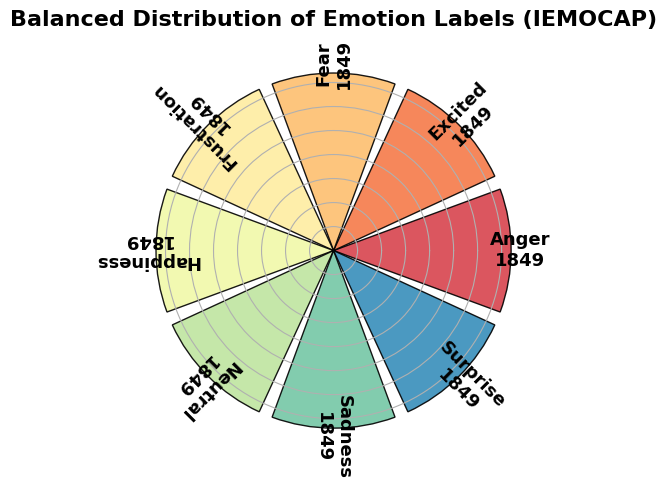

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming df_master_balanced is your balanced DataFrame
emotion_counts = df_master_balanced['emotion'].value_counts().sort_index()
emotions = emotion_counts.index.tolist()
counts = emotion_counts.values

# Polar coordinates
N = len(emotions)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
width = 2 * np.pi / N

# Color palette
palette = sns.color_palette("Spectral", n_colors=N)

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

bars = ax.bar(angles, counts, width=width*0.9, color=palette, edgecolor='black', alpha=0.9)

# Add emotion labels and counts on top of each bar
for angle, count, label in zip(angles, counts, emotions):
    rotation = np.degrees(angle)
    alignment = 'center'
    ax.text(angle, count + max(counts)*0.05, 
            f"{label.capitalize()}\n{count}", 
            ha=alignment, va='center', 
            fontsize=13, fontweight='bold', color='black', 
            rotation=rotation, rotation_mode='anchor')

# Remove radial gridlines and set style
ax.set_yticklabels([])
ax.set_xticks([])
ax.spines['polar'].set_visible(False)
ax.set_title('Balanced Distribution of Emotion Labels (IEMOCAP)', fontsize=16, fontweight='bold', y=1.08)

plt.tight_layout()
plt.show()

C:\Users\Rishuraj\AppData\Local\Temp\ipykernel_8892\2094850348.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette=palette)


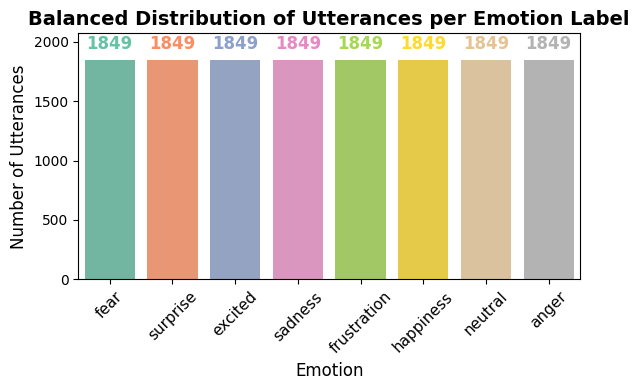

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_master_balanced is your balanced DataFrame
emotion_counts = df_master_balanced['emotion'].value_counts().sort_values(ascending=False)

palette = sns.color_palette("Set2", n_colors=len(emotion_counts))

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette=palette)

plt.title('Balanced Distribution of Utterances per Emotion Label', fontsize=14, weight='bold')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Number of Utterances', fontsize=12)
plt.xticks(rotation=45, fontsize=11)

# Add value labels with more vertical space
for i, count in enumerate(emotion_counts.values):
    plt.text(i, count + max(emotion_counts.values)*0.03, str(count), 
             ha='center', va='bottom', fontsize=12, fontweight='bold', color=palette[i])

# Increase upper y-limit for more headroom
plt.ylim(0, max(emotion_counts.values)*1.12)

plt.tight_layout()
plt.show()